# Quantum Fourier Transform

In [1]:
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Li

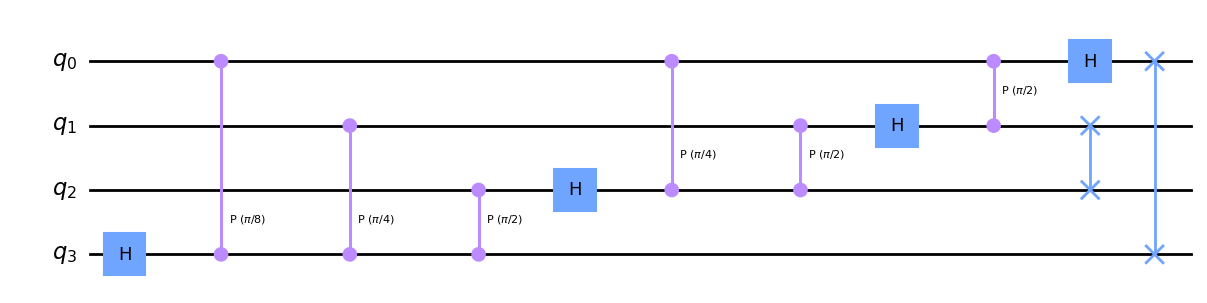

In [2]:
def qft_rotations(circuit, n):
    # Performs qft on the first n qubits in circuit (without swaps)
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n) # Recursive call

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    # QFT on the first n qubits in circuit
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qc = QuantumCircuit(4)
qft(qc,4)
qc.draw(output='mpl')

# Quantum Phase Estimation

In [3]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools and circuits
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

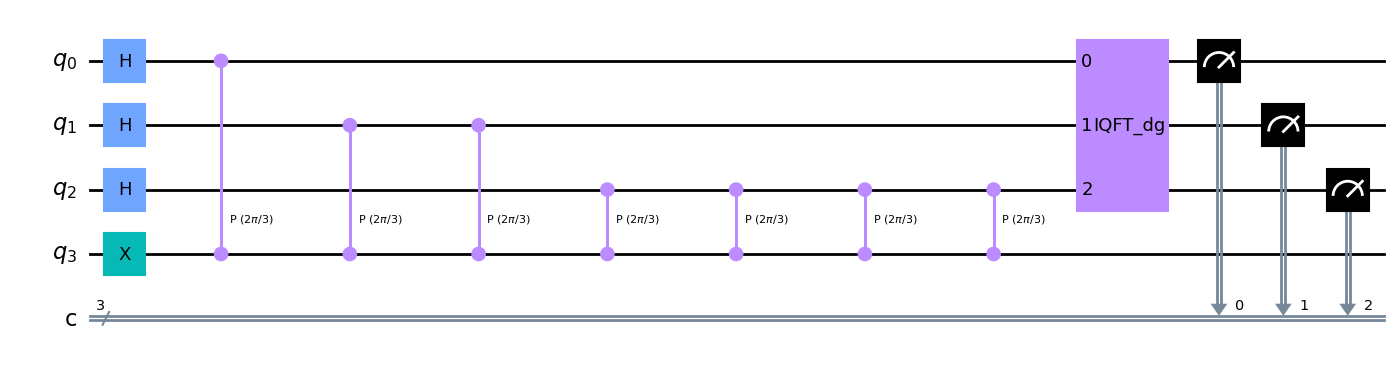

In [4]:
qpe2 = QuantumCircuit(4, 3)

# Applying H-Gates to counting qubits
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations
angle = 2*math.pi/3  # Taking angle = 2*pi*theta where theta = 1/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Inverse QFT
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

# Measurement
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw(output='mpl')

/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/thomasbijucheeramvelil/Li

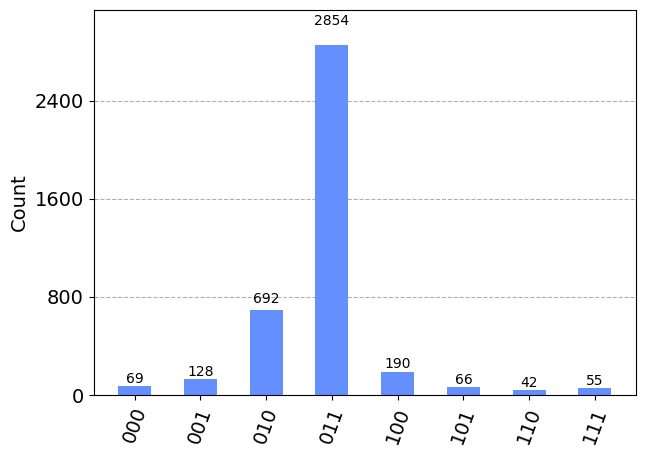

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result theta = 1/3, and we see our most likely results are 010(bin) = 2(dec) and 011(bin) = 3(dec). These two results would tell us that 2/8 = 0.25 (off by 25%) and 3/8 = 0.375 (off by 13%) respectively. The true value of theta lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision. To get more precision, we have to increase the number of counting bits.

# Shor's Algorithm used in Period Finding 

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

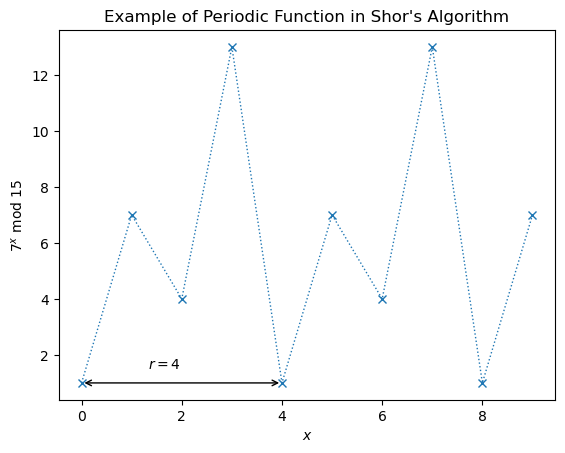

In [22]:
N = 15
a = 7

# Calculate the plotting data
xvals = np.arange(10)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

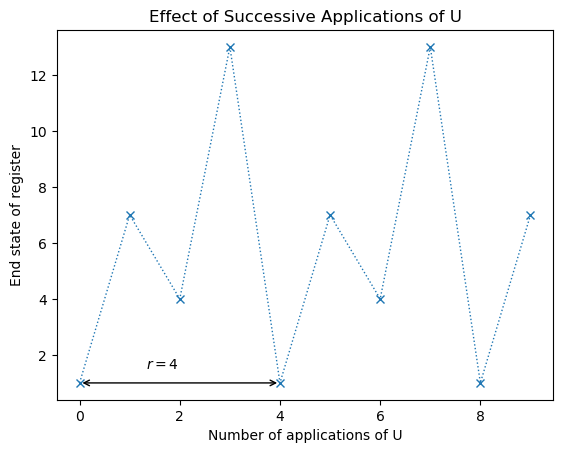

In [23]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [8]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [9]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

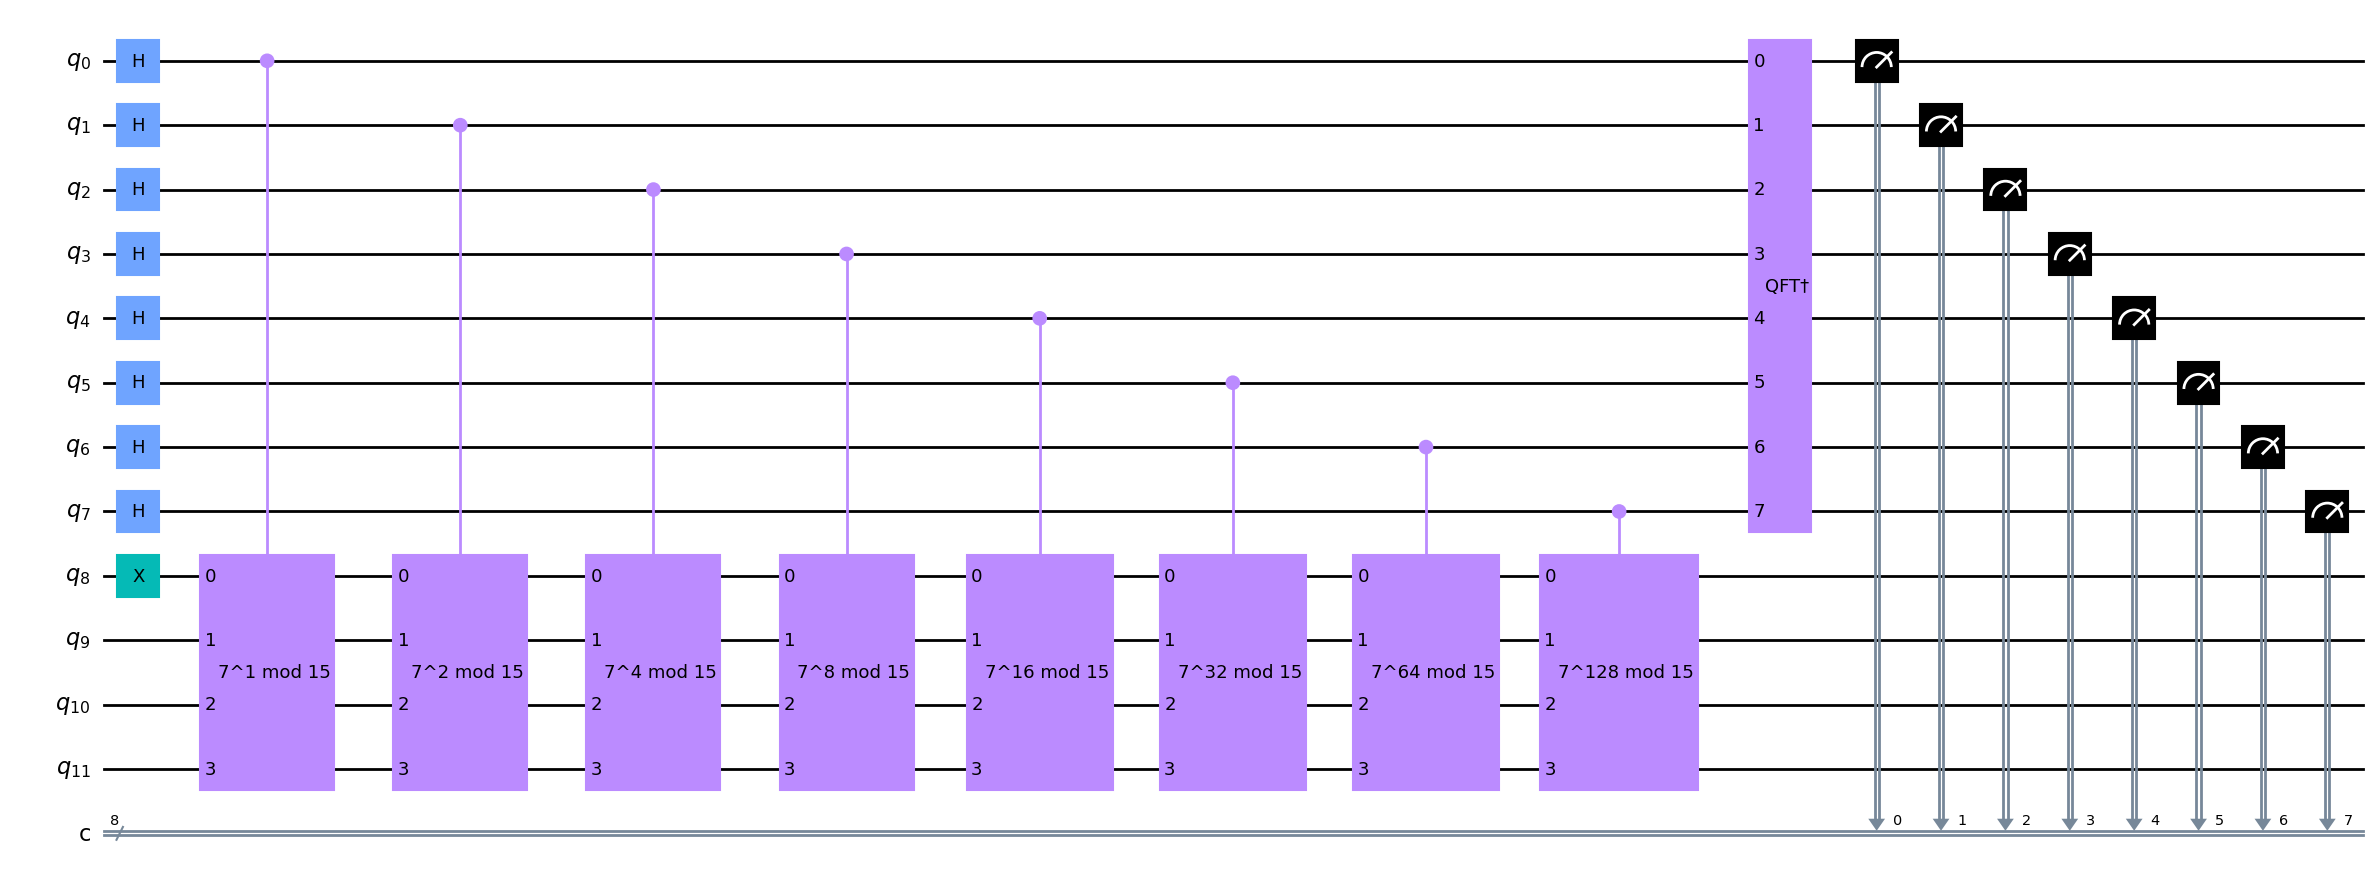

In [18]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1,output='mpl')  # -1 means 'do not fold'

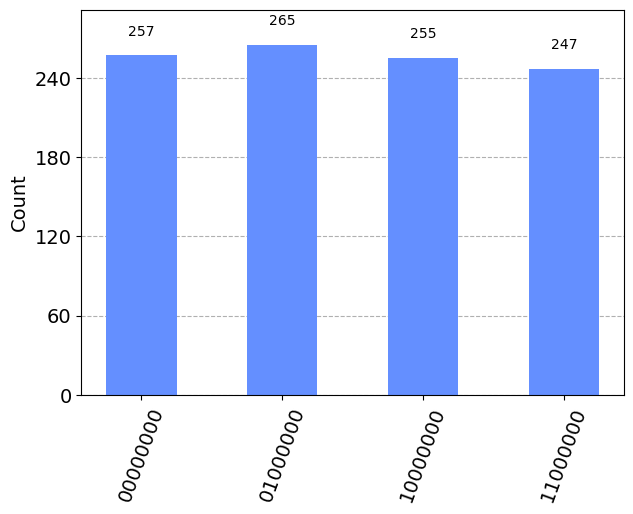

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [16]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [17]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.75      3/4            4
3   0.50      1/2            2


Hence, we get r = 4 as the period of the function f(x) = 7^x (mod 15)

# Grover's Search Algorithm

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [4]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

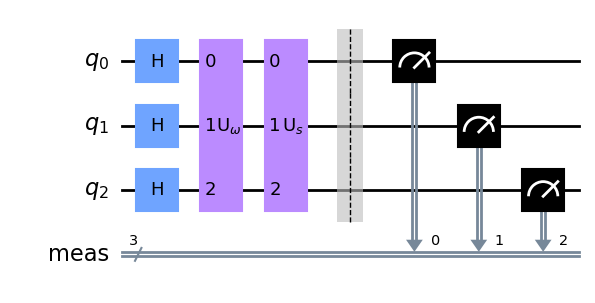

In [5]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw(output='mpl')

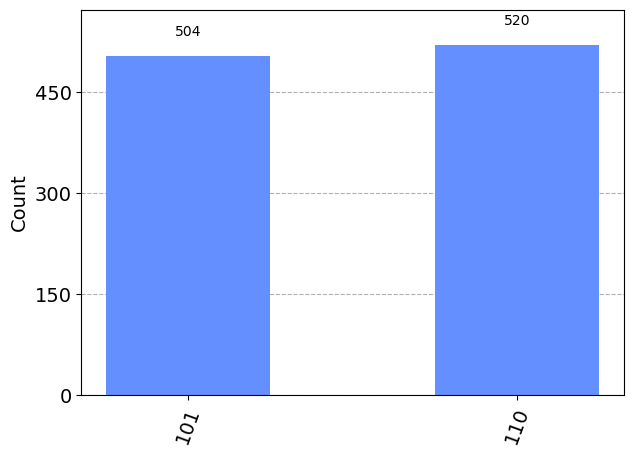

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

We got the states '101' and '110', which were the states we were searching for.